In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import os
import datetime
import pathlib
import matplotlib.dates as md
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import matplotlib.ticker as mtick
import matplotlib.dates as md

In [2]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def alignYaxes(axes, align_values=None):
    from matplotlib.pyplot import MaxNLocator

    nax=len(axes)
    ticks=[aii.get_yticks() for aii in axes]
    if align_values is None:
        aligns=[ticks[ii][0] for ii in range(nax)]
    else:
        if len(align_values) != nax:
            raise Exception("Length of <axes> doesn't equal that of <align_values>.")
        aligns=align_values

    bounds=[aii.get_ylim() for aii in axes]

    # align at some points
    ticks_align=[ticks[ii]-aligns[ii] for ii in range(nax)]

    # scale the range to 1-100
    ranges=[tii[-1]-tii[0] for tii in ticks]
    lgs=[-np.log10(rii)+2. for rii in ranges]
    igs=[np.floor(ii) for ii in lgs]
    log_ticks=[ticks_align[ii]*(10.**igs[ii]) for ii in range(nax)]

    # put all axes ticks into a single array, then compute new ticks for all
    comb_ticks=np.concatenate(log_ticks)
    comb_ticks.sort()
    locator=MaxNLocator(nbins='auto', steps=[1, 2, 2.5, 3, 4, 5, 8, 10])
    new_ticks=locator.tick_values(comb_ticks[0], comb_ticks[-1])
    new_ticks=[new_ticks/10.**igs[ii] for ii in range(nax)]
    new_ticks=[new_ticks[ii]+aligns[ii] for ii in range(nax)]

    # find the lower bound
    idx_l=0
    for i in range(len(new_ticks[0])):
        if any([new_ticks[jj][i] > bounds[jj][0] for jj in range(nax)]):
            idx_l=i-1
            break

    # find the upper bound
    idx_r=0
    for i in range(len(new_ticks[0])):
        if all([new_ticks[jj][i] > bounds[jj][1] for jj in range(nax)]):
            idx_r=i
            break

    # trim tick lists by bounds
    new_ticks=[tii[idx_l:idx_r+1] for tii in new_ticks]

    # set ticks for each axis
    for axii, tii in zip(axes, new_ticks):
        axii.set_yticks(tii)

    return new_ticks

In [3]:
def rescale_plot(W=5, l=6, w=3):
    plt.rcParams.update({
            'figure.figsize': (W, W/(l/w)),     # 6:3 aspect ratio
            'font.size' : 9,                   # Set font size to 11pt
            'axes.labelsize': 9,               # -> axis labels
            'legend.fontsize': 9,              # -> legends
            'font.family': 'lmodern',
            'text.usetex': True,
            'text.latex.preamble': (            # LaTeX preamble
                r'\usepackage{lmodern}'
                # ... more packages if needed
            )
        })

In [4]:
def get_LOB_data(data_path, asset_name, trade_date):
    LOB_data_path = os.path.join(data_path, asset_name, f'{asset_name}_{trade_date}_34200000_57600000_orderbook_5.csv')
    LOB_data      = pd.read_csv(LOB_data_path,
                                usecols   = [0, 1, 2, 3],
                                engine    = 'c',
                                index_col = None,
                                header    = None,
                                infer_datetime_format = True)

    LOB_messages = pd.read_csv(f'{data_path}/{asset_name}/{asset_name}_{trade_date}_34200000_57600000_message_5.csv', 
                               usecols   = [0,1],
                               engine    = 'c',
                               index_col = 0,
                               header    = None)
    LOB_data.index = LOB_messages.index
    LOB_data.columns = [f'ask_1', f'ask_volume_1', f'bid_1', f'bid_volume_1']
    LOB_data.index.name = 'time'
    LOB_data = LOB_data.reset_index(drop=False).groupby('time').last()
    
    return LOB_data, LOB_messages

In [5]:
def ema(series, periods, fillna=False):
    if fillna:
        return series.ewm(span=periods, min_periods=0).mean()
    return series.ewm(span=periods, min_periods=periods).mean()

def macd_signal_2(close, n_fast=12, n_slow=26, n_sign=9, fillna=False):
    emafast = ema(close, n_fast, fillna)
    emaslow = ema(close, n_slow, fillna)
    macd = emafast - emaslow
    macd = (macd - ema(macd, n_sign, fillna))
    macd = macd / close.shift(n_slow+n_fast)
    
    if fillna:
        macd = macd.replace([np.inf, -np.inf], np.nan).fillna(0)
        
    return pd.Series(macd, name='MACD')

In [6]:
def add_fwd_cols(all_fwd_cols, _LOB_features):
    for col in all_fwd_cols:
        fwd_w = int(col.split('_')[-1])
        _LOB_features[col] = _LOB_features['mid_price'].diff(fwd_w).shift(-fwd_w)

# Global variables

In [7]:
data_path     = pathlib.Path(os.path.abspath(os.path.join('..')), "data")
data_path     = pathlib.Path(os.path.abspath(os.path.join('..', '..')), "AOE3_data")
reward_path   = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Rewards")
feature_path  = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Features")

In [8]:
asset_names    = ("BIDU", "COST", "GILD", "DELL", "GOOG", "INTC")

In [9]:
tick_size     = 0.01

fwd_cols = []
fwd_col_l = (1, 5, 10, 20, 50, 40, 60, 100, 300, 500, 1000)
for w in fwd_col_l:
    fwd_cols += [f'fwd_price_move_{w}']

# Data Statistics
### Basic statistics

In [10]:
asset_stats = {}
for asset_name in asset_names:
    all_data = None
    len_data = 0
    avg_50trades = 0
    avg_frq = 0
    i_avg = 0
    events_per_minute = 0
    avg_volume_bbid = 0
    avg_volume_bask = 0
    avg_baspread = 0
    for filename in os.listdir(feature_path):
        f = os.path.join(feature_path, filename)
        # checking if it is a file
        if os.path.isfile(f):
            if asset_name in filename:
                trade_date = filename.split('_')[1]
                feature_fn = f'{asset_name}_{trade_date}_LOB_features.pkl'
                _all_data  = pd.read_pickle(f'{str(feature_path)}/{feature_fn}')
                
                # filter on important information
                try:
                    avg_volume_bbid   += _all_data.bid_volume_1.mean()
                    avg_volume_bask   += _all_data.ask_volume_1.mean()
                    
                    # relevant events per minute
                    events_per_minute += len(_all_data)/(6.5 * 60)
                    
                    # number of trades
                    len_data     += len(_all_data)
                    
                    # avg events for 50 trades
                    avg_50trades += _all_data['timestamp'].diff(20).replace({pd.NaT: np.nan}).dropna().apply(pd.Timedelta.total_seconds).mean()
                    avg_frq      += float(np.mean(np.diff(_all_data.timestamp)))/1e9
                    i_avg        += 1
                    
                    # avg ba spread
                    avg_baspread += _all_data['ba_spread'].mean()
                    
                except Exception as e:
                    print('Could not load asset ', asset_name, 'for date', trade_date)
                    print('error: ', str(e))
    if False:
        print('*************************')
        print(asset_name)
        print('*************************')
        print('Lenght of data', len_data)
        print('events per minute', events_per_minute    / i_avg)
        print('avg volume at best bid', avg_volume_bbid / i_avg)
        print('avg volume at best ask', avg_volume_bask / i_avg)
        print('avg time for 50 trades', avg_50trades    /i_avg)
        print('Average B/A spread', avg_baspread/i_avg/tick_size)
    
    asset_stats[asset_name] =  {'lendata': len_data, 
                                'events_per_minute' : events_per_minute    / i_avg,
                                'avg_volume_bbid'   : avg_volume_bbid / i_avg,
                                'avg_volume_bask'   : avg_volume_bask / i_avg,
                                'avg_50trades'      : avg_50trades    /i_avg,
                                'avg_freq'          : avg_frq    /i_avg,
                                'avg_baspread'      : avg_baspread/i_avg/tick_size}
                                

In [11]:
statsdf = pd.DataFrame.from_dict({asset_name: [asset_stats[asset_name][k] for k in asset_stats[asset_name].keys()] for asset_name in asset_names}) 
statsdf.index = asset_stats[asset_name].keys()
statsdf.T

,lendata,events_per_minute,avg_volume_bbid,avg_volume_bask,avg_50trades,avg_freq,avg_baspread
BIDU,6527016.0,288.550663,144.666986,143.594855,4.379803,0.218956,9.881444
COST,8539648.0,377.526437,70.543739,71.005566,4.082035,0.204064,29.871846
GILD,12982394.0,573.934306,411.891693,446.374009,2.110918,0.105537,1.795371
DELL,8231914.0,363.921927,287.497959,297.571909,3.386645,0.169398,1.840823
GOOG,45833859.0,1991.910430,369.627844,368.450109,0.599237,0.029961,1.624649
INTC,33807730.0,1469.262495,6607.306745,6332.021053,0.810294,0.040514,1.162990


In [27]:
60/210.56

0.28495440729483285

# Volume as a function of time

In [57]:
asset_names    = ("BIDU", )

In [59]:
volume_curve_dict = {}
vol_curve_dict = {}
for asset_name in asset_names:
    print('************', asset_name)
    volume_curve = None
    vol_curve = None
    for filename in os.listdir(os.path.join(data_path, asset_name)):
        f = os.path.join(data_path, asset_name, filename)
        # checking if it is a file
        if os.path.isfile(f):
            if 'message' in filename:
                trade_date = filename.split('_')[1]
                try:
                    LOB_data, LOB_messages = get_LOB_data(data_path, asset_name, trade_date)

                    LOB_data['timestamp']   = [datetime.datetime.strptime('1990-01-01', '%Y-%m-%d') + datetime.timedelta(seconds=i) for i in LOB_data.index]    

                    if volume_curve is None:
                        volume_curve = LOB_data[['ask_1', 'timestamp']].set_index('timestamp').resample("5min").count().fillna(0)
                    else:
                        volume_curve[trade_date] = LOB_data[['ask_1', 'timestamp']].set_index('timestamp').resample("5min").count().fillna(0)
                    
                    LOB_data['mid'] = (LOB_data['ask_1'] + LOB_data['bid_1'])/2/10000
                    if volume_curve is None:
                        vol_curve = LOB_data[['mid', 'timestamp']].set_index('timestamp').diff(1).rolling('5min').std()
                    else:
                        vol_curve[trade_date] = LOB_data[['mid', 'timestamp']].set_index('timestamp').diff(1).rolling('5min').std()
                        
                except Exception as e:
                    print('error :', trade_date)
    volume_curve_dict[asset_name] = volume_curve.fillna(0).sum(axis=1)/volume_curve.fillna(0).sum(axis=1).sum()
    vol_curve_dict[asset_name] = vol_curve.fillna(0).sum(axis=1)/vol_curve.fillna(0).sum(axis=1).sum()

************ BIDU
error : 2022-10-17


AttributeError: 'NoneType' object has no attribute 'fillna'

In [26]:
vol_curve_dict['BIDU'].resample('5min').mean().plot()

NameError: name 'vol_curve_dict' is not defined

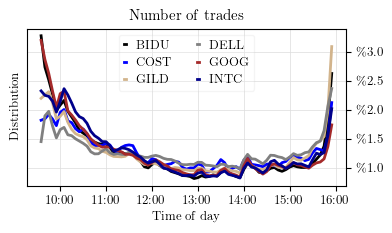

In [13]:
rescale_plot(W=4, l=5, w=3)

fig, ax1 = plt.subplots(1, 1, sharey=True, sharex=True, constrained_layout=True)

l_colors       = ("k", "blue", "tan", "grey", "brown", "darkblue", "purple")
_asset_names   = asset_names #("BIDU", "COST", "CSCO", "DELL")  # #

#trend
for (asset_name, l_color) in zip(_asset_names, l_colors):
    ax1.plot(volume_curve_dict[asset_name].index, 
             100*volume_curve_dict[asset_name].rolling(2).mean(), 
             color=l_color, lw=2)

for ax in (ax1,):
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("left")
    ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
ax1.legend(asset_names, loc='upper center', fancybox=True, framealpha=0.2, handlelength=0.2, ncol=2)
ax1.set_xlabel('Time of day')
ax1.set_ylabel('Distribution')
percc = normal2 = mtick.StrMethodFormatter('\%{x:,.1f}')
ax1.yaxis.set_major_formatter(percc)

ax1.set_title(r'Number of trades')
ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.tight_layout()
plt.savefig(f'plots/Ushaped.pdf', bbox_inches='tight')

# Signals predictive power

In [26]:
LOB_features.columns

Index(['mid_price', 'imbalance_1', 'ba_spread', 'timestamp',
       'macd_1200_2600_900', 'macd_120_260_90', 'macd_12_26_9', 'macd_8_24_9',
       'bid_volume_1', 'ask_volume_1', 'time_of_day', 'new_feature',
       'fwd_price_move_1', 'fwd_price_move_5', 'fwd_price_move_10',
       'fwd_price_move_20', 'fwd_price_move_50', 'fwd_price_move_40',
       'fwd_price_move_60', 'fwd_price_move_100', 'fwd_price_move_300',
       'fwd_price_move_500', 'fwd_price_move_1000'],
      dtype='object')

In [38]:
results = {}
cutoff_count = 10
rolling_normalizer_w = 300*30
for asset_name in asset_names:
    print('********************************')
    print('* ', asset_name)
    print('********************************')
    
    dic_results    = {}
    
    feature_1_name = 'macd_8_24_9'
    feature_2_name = 'imbalance_1'
    
    filenames      = os.listdir('../data/Features')
    trade_dates    = [fn.split('_')[1] for fn in filenames if asset_name in fn]
    
    for trade_date in trade_dates:
        #print('Reading:',trade_date)
        features_fn   = f'{asset_name}_{trade_date}_LOB_features.pkl'
        try:
            LOB_features = pd.read_pickle(f'../data/Features/{features_fn}')
            
            #LOB_features['new_feature'] = macd_signal_2(LOB_features['mid_price'], n_fast=8, n_slow=24, n_sign=9, fillna=True)    
            LOB_features[feature_2_name] = LOB_features[feature_2_name].round(1)
            
            
            # rescale macd features
            #(LOB_features[feature_1_name]/LOB_features[feature_1_name].abs().max()).round(1)   # rescale macd between -1 and 1
            #quantile03 = LOB_features[feature_1_name].quantile(0.001)
            #quantile07 = LOB_features[feature_1_name].quantile(0.999)
            #LOB_features.loc[LOB_features[((LOB_features[feature_1_name] < quantile03) | 
            #                                 (LOB_features[feature_1_name] > quantile07))].index, feature_1_name] = np.nan 
            
            rolling_max_macd = LOB_features[feature_1_name].max() #.rolling(rolling_normalizer_w)
            rolling_min_macd = LOB_features[feature_1_name].min() #.rolling(rolling_normalizer_w)
            LOB_features[feature_1_name] = -1.4 + 2.4 * (LOB_features[feature_1_name] - rolling_min_macd) / (rolling_max_macd - rolling_min_macd)
            LOB_features[feature_1_name] = LOB_features[feature_1_name].round(1)
            
            add_fwd_cols(fwd_cols, LOB_features)
            
            LOB_features_predictive = LOB_features[[feature_1_name, feature_2_name] + fwd_cols].dropna()

            predictive_feature = feature_1_name
            counts1 = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).count())
            avgs1   = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).mean())
            #clear_output()
            avgs1[counts1<cutoff_count] = np.nan
            
            # normalise MACD
            avgs1       = avgs1.sort_index()#.fillna(method='ffill').fillna(method='bfill')
            
            # hit ratio
            hitratio1 = []
            for fwd_col in fwd_cols:
                prediction_  =  - (LOB_features[predictive_feature]>0).astype(int) + (LOB_features[predictive_feature]<0).astype(int) # macd
                hitratio1 += [(prediction_ == LOB_features[fwd_col].apply(np.sign)).astype(int).describe()['mean']]
                
            predictive_feature = feature_2_name
            counts2 = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).count())
            avgs2   = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).mean())
            avgs2[counts2<cutoff_count]=np.nan
            avgs2 = avgs2.sort_index()#.fillna(method='ffill').fillna(method='bfill')
            
            # hit ratio
            hitratio2 = []
            for fwd_col in fwd_cols:
                prediction_  =  - (LOB_features[predictive_feature]<0).astype(int)  + (LOB_features[predictive_feature]>0).astype(int) # imbalance
                hitratio2 += [(prediction_ == LOB_features[fwd_col].apply(np.sign)).astype(int).describe()['mean']]
                
            dic_results[trade_date] = (counts1, avgs1, counts2, avgs2, hitratio1, hitratio2)

        except Exception as e:
            print('Could not load asset ', asset_name, 'for date', trade_date)
            print(str(e))
    
    results[asset_name] = dic_results

********************************
*  BIDU
********************************
********************************
*  COST
********************************
********************************
*  GILD
********************************
********************************
*  DELL
********************************
********************************
*  GOOG
********************************
********************************
*  INTC
********************************


In [39]:
avg_results  = {}
_results     = {}
smooth_w_1   = 4
smooth_w_2   = 1
#hitratios   = []

# Cleaning of results
for asset_name in asset_names:
    avg_results[asset_name] = {}
    tmp_dico = {}
    for s in results[asset_name].keys():
        counts1, avgs1, counts2, avgs2, hitratios1, hitratio2 = results[asset_name][s]
        _counts1, _avgs1, _counts2, _avgs2 = counts1.copy(), avgs1.copy(), counts2.copy(), avgs2.copy()

        #_avgs1 = _avgs1[_counts1>cutoff_count].dropna(); _avgs2 = _avgs2[_counts2>cutoff_count].dropna()
        # rescale MACD to make it comparable
        #_avgs1.index = np.round(_avgs1.index/np.max(np.abs(np.array(_avgs1.index))), 1)
        #_avgs2.index = np.round(_avgs2.index/np.max(np.abs(np.array(_avgs2.index))), 1)
        
        _avgs1 = _avgs1/asset_stats[asset_name]['avg_baspread']/tick_size
        _avgs2 = _avgs2/asset_stats[asset_name]['avg_baspread']/tick_size
        
        tmp_dico[s] = (_avgs1.sort_index(), _avgs2.sort_index())
    for fwd_col in fwd_cols:
        avg_results[asset_name][fwd_col] = (pd.concat((tmp_dico[s][0][fwd_col] for s in tmp_dico.keys()), axis=1).sort_index().mean(axis=1), 
                                               pd.concat((tmp_dico[s][1][fwd_col] for s in tmp_dico.keys()), axis=1).sort_index().mean(axis=1))     
        avg_results[asset_name][fwd_col] = (avg_results[asset_name][fwd_col][0][::-1].rolling(smooth_w_1).mean()[::-1].rolling(smooth_w_1).mean(), 
                                            avg_results[asset_name][fwd_col][1][::-1].rolling(smooth_w_2).mean()[::-1].rolling(smooth_w_2).mean())

fwd_price_move_20
fwd_price_move_50


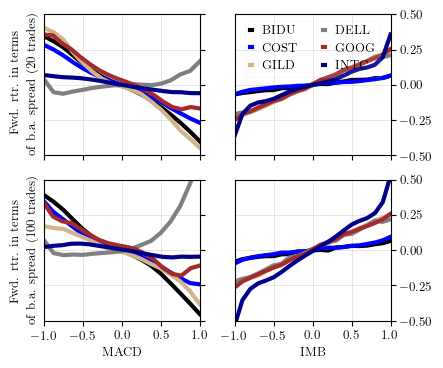

In [40]:
fwd_col_l_ = 3
fwd_col_l_2 = 4
print(fwd_cols[fwd_col_l_])
print(fwd_cols[fwd_col_l_2])

rescale_plot(W=4.5, l=6, w=5)

plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True 
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, sharex=True)

l_colors       = ("k", "blue", "tan", "grey", "brown", "darkblue", "purple")
_asset_names   = asset_names #("BIDU", "COST", "CSCO", "DELL")  # #


for (asset_name, l_color) in zip(_asset_names, l_colors):
    avgs1, avgs2 = avg_results[asset_name][fwd_cols[fwd_col_l_]] #avg_results[asset_name]
    #if asset_name == 'DELL':
        #avgs1 = avgs1[::-1].rolling(2).mean()[::-1]
    avgs1_ = avgs1.copy().dropna()
    avgs1_.index = - 1 + 2 * (avgs1.dropna().index - avgs1.dropna().index.min()) /(avgs1.dropna().index.max() - avgs1.dropna().index.min())    
    ax1.plot(avgs1_, color=l_color, lw=3)
    ax2.plot(avgs2, color=l_color, lw=3)
    
    avgs1, avgs2 = avg_results[asset_name][fwd_cols[fwd_col_l_2]] #avg_results[asset_name]
    #if asset_name == 'DELL':
        #avgs1 = avgs1[::-1].rolling(2).mean()[::-1]
    avgs1_ = avgs1.copy().dropna()
    avgs1_.index = - 1 + 2 * (avgs1.dropna().index - avgs1.dropna().index.min()) /(avgs1.dropna().index.max() - avgs1.dropna().index.min())    
    ax3.plot(avgs1_, color=l_color, lw=3)
    ax4.plot(avgs2, color=l_color, lw=3)
    
for ax in (ax1,ax2, ax3, ax4):
    ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
ax1.yaxis.set_label_position("left")
ax2.yaxis.set_label_position("right")


ax2.legend(_asset_names, loc='upper center', fancybox=True, framealpha=0.1, handlelength=0.2, ncol=2)

ax1.set_ylabel('Fwd. rtr. in terms' + r'\\' + 'of b.a. spread (20 trades)')
ax3.set_ylabel('Fwd. rtr. in terms' + r'\\' + 'of b.a. spread (100 trades)')

ax3.set_xlabel('MACD')
ax4.set_xlabel('IMB')

ax1.set_ylim(-0.5, 0.5)
ax1.set_yticks((-0.5, -0.25, 0, 0.25, 0.5))

ax1.set_xlim(-1, 1)
plt.tight_layout()
plt.savefig(f'plots/AOE0.pdf', bbox_inches='tight')

# Evidence of signals mixing being bad

In [17]:
asset_name   = 'BIDU'
fwd_window   = 'fwd_price_move_20'

dict_acc = {}

for asset_name in asset_names:
    print('****', asset_name)
    accuracy_MACD = []
    accuracy_Imbalance = []
    accuracy_Both = []
    accuracy_MACD2 = []
    accuracy_Imbalance2 = []
    accuracy_Both2 = []
    
    filenames    = os.listdir('../data/Features')
    trade_dates  = [fn.split('_')[1] for fn in filenames if asset_name in fn]

    for trade_date in trade_dates:
        feature_fn = f'{asset_name}_{trade_date}_LOB_features.pkl'
        _all_data  = pd.read_pickle(f'{str(feature_path)}/{feature_fn}')#.set_index('timestamp')
        _all_data['new_feature'] = macd_signal_2(_all_data['mid_price'], n_fast=8, n_slow=24, n_sign=9, fillna=True)    

        _all_data["prediction_MACD"] =  - (_all_data["new_feature"]>0).astype(int) + (_all_data["new_feature"]<0).astype(int)
        _all_data["prediction_IMB"]  =  - (_all_data["imbalance_1"]<0).astype(int) + (_all_data["imbalance_1"]>0).astype(int)
        _all_data["oracle"]          =  _all_data.mid_price.diff(20).shift(-20).apply(np.sign)
        
        _all_data = _all_data[_all_data.oracle != 0]
        accuracy_Imbalance += [((_all_data["prediction_IMB"] == _all_data["oracle"]).astype(int).value_counts()/len(_all_data))[1]]
        accuracy_MACD += [((_all_data["prediction_MACD"] == _all_data["oracle"]).astype(int).value_counts()/len(_all_data))[1]]
        accuracy_Both += [(((_all_data["prediction_MACD"] + _all_data["prediction_IMB"]).apply(np.sign)==_all_data["oracle"]).astype(int).value_counts()/len(_all_data))[1]]
        
        _all_data2 = _all_data[_all_data.imbalance_1.abs() > _all_data.imbalance_1.abs().quantile(0.8)]
        accuracy_Imbalance2 += [((_all_data2["prediction_IMB"] == _all_data2["oracle"]).astype(int).value_counts()/len(_all_data2))[1]]
        
        _all_data3 = _all_data.copy()
        _all_data3['new_feature'] = - 1 + 2 * (_all_data3['new_feature'] - _all_data3['new_feature'].min()) /(_all_data3['new_feature'].max() - _all_data3['new_feature'].min())    
        _all_data3 = _all_data3[_all_data3.new_feature.abs() > _all_data3.new_feature.abs().quantile(0.8)]
        accuracy_MACD2 += [((_all_data3["prediction_IMB"] == _all_data3["oracle"]).astype(int).value_counts()/len(_all_data3))[1]]
        
        waw = (_all_data2[~_all_data2.index.duplicated(keep='first')].reindex(_all_data.index)['new_feature'].fillna(0) + \
             _all_data3[~_all_data3.index.duplicated(keep='first')].reindex(_all_data.index)['imbalance_1'].fillna(0)).apply(np.sign)
        
        accuracy_Both2 += [((waw ==_all_data["oracle"]).astype(int).value_counts()/len(_all_data))[1]]
        
    dict_acc[asset_name] = (accuracy_Imbalance, accuracy_MACD, accuracy_Both, accuracy_Imbalance2, accuracy_MACD2, accuracy_Both2)
#_all_data

**** BIDU
**** COST
**** GILD
**** DELL
**** GOOG
**** INTC


In [18]:
resultsDF = pd.DataFrame.from_dict({asset_name: [ np.mean(dict_acc[asset_name][i]) for i in range(6)] for asset_name in asset_names})
resultsDF.index = ['IMB', 'MACD', 'BOTH', 'IMB2', 'MACD2', 'BOTH2']
100*resultsDF.T

,IMB,MACD,BOTH,IMB2,MACD2,BOTH2
BIDU,52.488615,51.580555,31.324651,58.561476,51.983289,18.177834
COST,53.468871,53.194155,31.970722,61.072082,52.990601,18.136886
GILD,61.334777,49.161369,33.977531,74.749575,56.657924,19.158869
DELL,58.890339,49.707218,32.334217,73.244217,54.662191,19.235001
GOOG,61.102692,50.229793,32.738896,72.669785,58.495598,19.440274
INTC,82.798108,52.448800,45.754211,98.791860,73.355295,23.773639


# Evidence of non stationarity

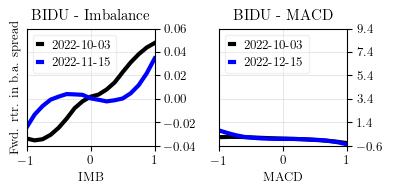

In [19]:
asset_name   = 'BIDU'
fwd_window   = 'fwd_price_move_20'
filenames    = os.listdir('../data/Features')
trade_dates  = [fn.split('_')[1] for fn in filenames if asset_name in fn]

trade_date_1 = np.sort(trade_dates)[0]
trade_date_2 = np.sort(trade_dates)[30]
smooth_w_1   = 3

rescale_plot(W=4, l=6, w=3)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=True, constrained_layout=True)

l_colors       = ("k", "blue", "tan", "grey", "brown", "darkblue", "purple")

for (trade_date_, ax_, l_color) in zip((trade_date_1, trade_date_2), (ax1, ax1), l_colors):
    counts1, avgs1, counts2, avgs2, hitratio1, hitratio2 = results[asset_name][trade_date_]
    avgs1  = avgs2[::-1].rolling(smooth_w_1).mean()[::-1].rolling(smooth_w_1).mean()
    _avgs1 = avgs1/asset_stats[asset_name]['avg_baspread']/tick_size
    _avgs1 = _avgs1.copy().dropna()[fwd_window]
    _avgs1.index = - 1 + 2 * (_avgs1.dropna().index - _avgs1.dropna().index.min()) /(_avgs1.dropna().index.max() - _avgs1.dropna().index.min())    
    ax_.plot(_avgs1, color=l_color, lw=3)
    
for ax in (ax1,):
    ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_right()
ax1.legend([trade_date_1, trade_date_2], loc='upper left', fancybox=True, framealpha=0.3, handlelength=0.3, ncol=1)

ax1.set_ylabel('Fwd. rtr. in b.a. spread')
ax1.set_xlabel('IMB')
ax1.set_title(f'{asset_name} - Imbalance')

ax3          = ax1 
ax1          = ax2
trade_date_1 = np.sort(trade_dates)[0] #32 51
trade_date_2 = np.sort(trade_dates)[51] #20

for (trade_date_, ax_, l_color) in zip((trade_date_1, trade_date_2), (ax1, ax1), l_colors):
    counts1, avgs1, counts2, avgs2, hitratio1, hitratio2 = results[asset_name][trade_date_]
    avgs1  = avgs1[::-1].rolling(smooth_w_1).mean()[::-1].rolling(smooth_w_1).mean()
    _avgs1 = avgs1/asset_stats[asset_name]['avg_baspread']/tick_size
    _avgs1 = _avgs1.copy().dropna()[fwd_window]
    _avgs1.index = - 1 + 2 * (_avgs1.dropna().index - _avgs1.dropna().index.min()) /(_avgs1.dropna().index.max() - _avgs1.dropna().index.min())    
    ax_.plot(_avgs1, color=l_color, lw=3)
    
for ax in (ax1,):
    ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_right()
ax1.legend([trade_date_1, trade_date_2], loc='upper left', fancybox=True, framealpha=0.3, handlelength=0.3, ncol=1)
ax1.set_xlabel('MACD')
ax1.set_title(f'{asset_name} - MACD')

ax1.set_xlim(-1, 1)
ax1.set_ylim(-0.5, 0.5)

alignYaxes((ax3, ax2))

plt.tight_layout()
plt.savefig(f'plots/NS_PLOT.pdf', bbox_inches='tight')

In [20]:
i = 7

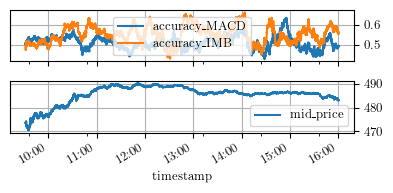

In [21]:
asset_name   = 'COST'
fwd_window   = 'fwd_price_move_20'

filenames    = os.listdir('../data/Features')
trade_dates  = [fn.split('_')[1] for fn in filenames if asset_name in fn]
trade_date   = trade_dates[i] #-15
i+=1
feature_fn = f'{asset_name}_{trade_date}_LOB_features.pkl'
_all_data  = pd.read_pickle(f'{str(feature_path)}/{feature_fn}')#.set_index('timestamp')
_all_data['new_feature'] = macd_signal_2(_all_data['mid_price'], n_fast=8, n_slow=24, n_sign=9, fillna=True)    

_all_data["prediction_MACD"] =  - (_all_data["new_feature"]>0).astype(int) + (_all_data["new_feature"]<0).astype(int)
_all_data["prediction_IMB"]  =  - (_all_data["imbalance_1"]<0).astype(int) + (_all_data["imbalance_1"]>0).astype(int)
_all_data["oracle"]          =  _all_data.mid_price.diff(20).shift(-20).apply(np.sign)

_all_data["accuracy_MACD"] = (_all_data["prediction_MACD"] == _all_data["oracle"]).astype(int)
_all_data["accuracy_IMB"] = (_all_data["prediction_IMB"] == _all_data["oracle"]).astype(int)

_all_data = _all_data[_all_data.oracle != 0]

if True:
    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    _all_data.set_index('timestamp')[["accuracy_MACD", "accuracy_IMB"]].rolling('10min').mean().iloc[1000:].plot(ax=ax)
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    _all_data.set_index('timestamp')[['mid_price']].iloc[1000:].plot(ax=ax2)
    ax.grid('both'); ax2.grid('both')
    plt.tight_layout()
    plt.show()

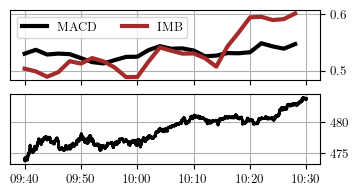

In [23]:
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True)
ax1.plot(_all_data.set_index('timestamp').mid_price.between_time('09:40', '10:30'), color='k', lw=2)
rolling_accuracy  =_all_data.set_index('timestamp')[["accuracy_MACD", "accuracy_IMB"]].rolling('10min').mean().rolling(10).mean().between_time('09:40', '10:30')
ax2.plot(rolling_accuracy.resample('2min').mean().index, rolling_accuracy.resample('2min').mean().iloc[:, 0], color='k', lw=3)
ax2.plot(rolling_accuracy.resample('2min').mean().index, rolling_accuracy.resample('2min').mean().iloc[:, 1], color='brown', lw=3)

ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax1.grid('both'); ax2.grid('both')
ax2.legend(['MACD', 'IMB'], ncol=2)

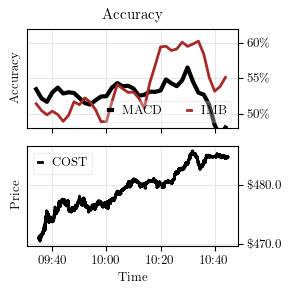

In [24]:
rescale_plot(W=3, l=4, w=4)

fig, (ax2, ax1) = plt.subplots(2, 1, sharey=False, sharex=True, constrained_layout=True)

l_colors       = ("k", "blue", "tan", "grey", "brown", "darkblue", "purple")

ax1.plot(_all_data.set_index('timestamp').mid_price.between_time('09:35', '10:45'), color='k', lw=2)
rolling_accuracy  =_all_data.set_index('timestamp')[["accuracy_MACD", "accuracy_IMB"]].rolling('10min').mean().between_time('09:35', '10:45')

ax2.plot(rolling_accuracy.resample('2min').mean().index, 100*rolling_accuracy.resample('2min').mean().iloc[:, 0], color='k', lw=3)
ax2.plot(rolling_accuracy.resample('2min').mean().index, 100*rolling_accuracy.resample('2min').mean().iloc[:, 1], color='brown', lw=2)

ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_right()
ax1.legend([asset_name], loc='best', fancybox=True, framealpha=0.3, handlelength=0.3, ncol=1)

ax1.set_ylabel('Price')
ax2.set_ylabel('Accuracy')

for ax in (ax1, ax2):
    ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_right()

ax2.legend(['MACD', 'IMB'], loc='lower right', fancybox=True, framealpha=0.3, handlelength=0.3, ncol=2)
ax1.set_xlabel('Time')
ax2.set_title(f'Accuracy')
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}\%'))
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('\${x:,.1f}'))

#alignYaxes((ax1, ax2))
ax2.set_ylim(48,62)
ax2.set_yticks((50, 55, 60))
ax1.set_xticks(ax1.get_xticks()[::2])
plt.tight_layout()
plt.savefig(f'plots/NS_PLOT_2.pdf', bbox_inches='tight')